#### Copyright 2019 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Polynomial Regression and Overfitting

We have spent a substantial amount of time on linear models so far in this course. Most of these models have been "straight-line" models where we attempt to draw a line that fits a regression or a line that is used to make a binary decision to a single feature.

In cases where we have had more than one feature, we have relied on underlying [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) implementations to project important factors about the features onto a data plane that we can dissect with a straight line.

We will diverge from this a bit today and build a model based on a [polynomial equation](https://en.wikipedia.org/wiki/Polynomial).

## Overview

### Learning Objectives

* Apply polynomial models to regression problems
* Recognize when a model might be overfitting
* Combat overfitting using techniques such as Lasso, Ridge, and ElasticNet regularization

### Prerequisites

* TODO(jmcadams)

### Estimated Duration

60 minutes

### Grading Criteria

Each exercise is worth 3 points. The rubric for calculating those points is:

| Points | Description |
|--------|-------------|
| 0      | No attempt at exercise |
| 1      | Attempted exercise, but code does not run |
| 2      | Attempted exercise, code runs, but produces incorrect answer |
| 3      | Exercise completed successfully |

There are 2 exercises in this Colab so there are 6 points available. The grading scale will be 6 points.

## Generate sample data

For this Colab let's start by generating some data on a polynomial curve with a degree 2 polynomial.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

num_items = 100

np.random.seed(seed=420)
X = np.random.randn(num_items, 1)

y = 0.6*(X**2) - 0.4*X + 1.3

plt.plot(X, y, 'b.')
plt.show()

<Figure size 640x480 with 1 Axes>

That gives us a nice polynomial grin, but let's add some randomness to create a more realistic dataset and plot the randomized data points and the fit line again.

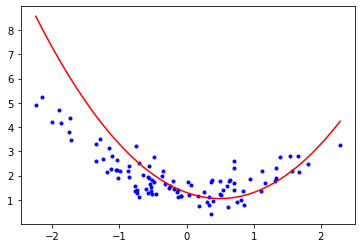

In [3]:
import numpy as np
import matplotlib.pyplot as plt

num_items = 100

np.random.seed(seed=420)
X = np.random.randn(num_items, 1)
y = 0.6*(X**2) - 0.4*X + 1.3 + np.random.randn(num_items, 1)/2

X_line = np.linspace(X.min(), X.max(), num=num_items)
y_line = (X_line**2) - X_line + 1.3

plt.plot(X, y, 'b.')
plt.plot(X_line, y_line, 'r-')
plt.show()

That looks much better! Now we can see that a 2-degree polynomial function fits this data reasonably well.

## Polynomial fitting

At this point we have one feature and can see a pretty obvious 2-degree polynomial in the scatterplot. How do we model this?

Scikit Learn offers a `PolynomialFeatures` class that handles polynomial combinations on a linear model. In this case we have seen that a 2-degree polynomial looks like a good fit. Let's see if the model works.

We begin by creating a `PolynomialFeatures` instance of degree 2.

You might be wondering what the `include_bias` parameter is? By default it is `True` and by it causes the first exponent to be 0, which always creates a value of 1.

What does this do? It adds a constant bias term to the equation. When we ask for no bias we start our exponents at 1 instead of 0.

In [4]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2, include_bias=False)
X_poly = pf.fit_transform(X)

X.shape, X_poly.shape

((100, 1), (100, 2))

This preprocessor generates new feature matrix consisting of all polynomial combinations of the features. Notice how or input shape of `(100, 1)` becomes `(100, 2)` after transformation.

In this simple case we just doubled the number of features since we asked for a 2-degree polynomial and only had one input feature. The number of generated features actually grows exponentially as the number of features and polynomial degrees increases.

## Fit the model

We can now fit the model by passing our polynomial preprocessing data to the linear regressor.

How close did the intercept and coefficient match the values in the function we used to generate our data?

In [5]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

lin_reg.intercept_, lin_reg.coef_

(array([1.36103165]), array([[-0.35327962,  0.61333818]]))

## Visualization

And we can plot our fitted line against the actual equation used to generate the data. Our fitted line is green and the actual is red.

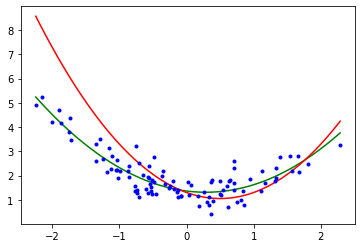

In [6]:
np.random.seed(seed=420)

X_line_fitted = np.linspace(X.min(), X.max(), num=100)
y_line_fitted = lin_reg.coef_[0][1] * X_line_fitted**2 + lin_reg.coef_[0][0] * X_line_fitted + lin_reg.intercept_

plt.plot(X_line_fitted, y_line_fitted, 'g-')
plt.plot(X_line, y_line, 'r-')
plt.plot(X, y, 'b.')
plt.show()

# Overfitting

When using polynomial regressions it can be easy to *overfit* the data so that it performs well on the training and testing data, but doesn't perform well in the real world.

To understand what overfitting is, let's create a visualization to illustrate. We will do this by creating a fake dataset generated off of a linear equation, but then use a polynomial regression as the model.

## Generate sample data

First we will generate some data using a purely linear model.

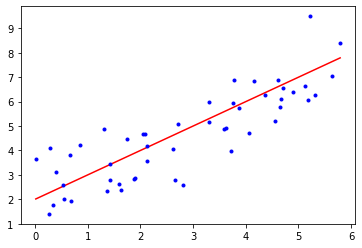

In [7]:
np.random.seed(seed=420)

num_items = 50
X = 6 * np.random.rand(num_items, 1)
y = X + 2 + np.random.randn(num_items, 1)

X_line = np.array([X.min(), X.max()])
y_line = X_line + 2

plt.plot(X_line, y_line, 'r-')
plt.plot(X, y, 'b.')
plt.show()

## Fit a polynomial model

Let's now create a 10 degree polynomial to fit the linear data and fit the model.

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

np.random.seed(seed=420)

poly_features = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly_features.fit_transform(X)

regression = LinearRegression()
regression.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Visualization

We will now draw the polynomial line that we fit to the linear model. To draw the line we need to execute the 10 degree polynomial equation.

```
  a + b*x^1 + c*x^2 + d*x^3 + ... + j*x^9 + k*x^10
```

Creating the above equation by hand is tedious and error-prone. It also makes it difficult to change the degree of the polynomial we are fitting.

Let's peek into the data provided by the `PolynomialFeatures` and `LinearRegression` functions and see if there is a way to write the code more dynamically.

Our `PolynomialFeatures` class provides us with a list of exponents that we can use for each portion of the polynomial equation.

In [9]:
poly_features.powers_

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])

Our `LinearRegression` provides us with a list of coefficients that line up with the powers provided by `PolynomialFeatures`.

In [10]:
regression.coef_

array([[-1.93762876e+01,  7.75135831e+01, -1.38337775e+02,
         1.36694413e+02, -8.16237576e+01,  3.06089393e+01,
        -7.24294715e+00,  1.04853764e+00, -8.47161797e-02,
         2.92466572e-03]])

It also provides us with an intercept.

In [11]:
regression.intercept_

array([3.98338796])

Having this information, we can take a set of X values (in the code below we use 100) and then run our equation on those values.

In [12]:
np.random.seed(seed=420)

# Create 100 even-spaced x-values
X_line_fitted = np.linspace(X.min(), X.max(), num=100)

# Start our equation with the intercept
y_line_fitted = regression.intercept_

# For each exponent raise the X value to that exponent and multiple it by the
# appropriate coefficient
for i in range(len(poly_features.powers_)):
  exponent = poly_features.powers_[i][0]
  y_line_fitted = y_line_fitted + regression.coef_[0][i] * (X_line_fitted**exponent)

We can now plot the data points, the actual line used to generate them, and our fitted model.

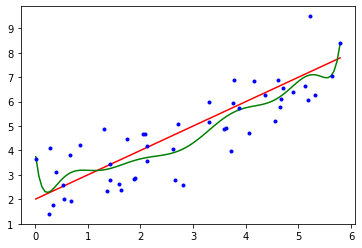

In [13]:
plt.plot(X_line, y_line, 'r-')
plt.plot(X_line_fitted, y_line_fitted, 'g-')
plt.plot(X, y, 'b.')
plt.show()

Notice how our line is very wavy and likely spikes up or down at the ends. This is a sign of overfitting. The line fits the training data reasonably well, but will not likely be very useful on new data.

## Using a simpler model

The most obvious way to prevent overfitting in this example is to simply reduce the degree of the polynomial or revert to a linear model.

The code below uses a two degree polynomial and seems to fit the data much better. A linear model would be good too.

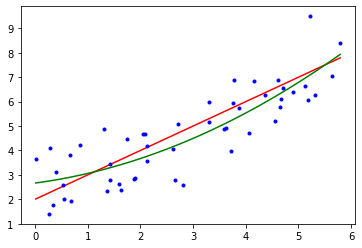

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

regression = LinearRegression()
regression.fit(X_poly, y)

X_line_fitted = np.linspace(X.min(), X.max(), num=100)
y_line_fitted = regression.intercept_
for i in range(len(poly_features.powers_)):
  exponent = poly_features.powers_[i][0]
  y_line_fitted = y_line_fitted + regression.coef_[0][i] * (X_line_fitted**exponent)

plt.plot(X_line, y_line, 'r-')
plt.plot(X_line_fitted, y_line_fitted, 'g-')
plt.plot(X, y, 'b.')
plt.show()

## Lasso regularization

You don't always have such an obvious case where a simpler model is definitely the correct choice. Sometimes you have to rely on regularization methods that penalize large coefficients.

Least Absolute Shrinkage and Selection Operator (Lasso) regularization, also called L1 regularization, is a regularization method that adds the sum of the absolute values of the coefficients as a penality in a cost function.

In Scikit learn we can use the [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) model which performs a linear regression with an L1 regression penalty.

In the resultant graph you can see that the regression smooths out our polynomial curve quite a bit, despite the polynomial being a degree 10 polynomial.

Note that Lasso regression can make the impact of less important features completely disappear.

/Users/dorishuang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.45391630398585, tolerance: 0.01633157498379137
  positive)


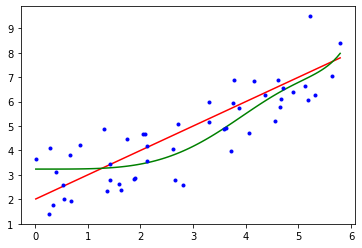

In [15]:
from sklearn.linear_model import Lasso

poly_features = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly_features.fit_transform(X)

lasso_reg = Lasso(alpha=5.0)
lasso_reg.fit(X_poly, y)

X_line_fitted = np.linspace(X.min(), X.max(), num=100)
y_line_fitted = lasso_reg.intercept_
for i in range(len(poly_features.powers_)):
  exponent = poly_features.powers_[i][0]
  y_line_fitted = y_line_fitted + lasso_reg.coef_[i] * (X_line_fitted**exponent)

plt.plot(X_line, y_line, 'r-')
plt.plot(X_line_fitted, y_line_fitted, 'g-')
plt.plot(X, y, 'b.')
plt.show()

## Ridge regularization

Similar to Lasso regularization, [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) regularization adds a penality to the cost function of a model. In the case of Ridge regularization, also called L2 regularization, the penality is the square of the coefficient.

Again we can see that the regression smooths out the curve of our large-degree polynomial.

/Users/dorishuang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.5572e-17): result may not be accurate.
  overwrite_a=True).T


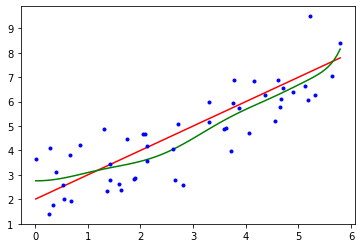

In [16]:
from sklearn.linear_model import Ridge

poly_features = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly_features.fit_transform(X)

ridge_reg = Ridge(alpha=0.5)
ridge_reg.fit(X_poly, y)

X_line_fitted = np.linspace(X.min(), X.max(), num=100)
y_line_fitted = ridge_reg.intercept_
for i in range(len(poly_features.powers_)):
  exponent = poly_features.powers_[i][0]
  y_line_fitted = y_line_fitted + ridge_reg.coef_[0][i] * (X_line_fitted**exponent)

plt.plot(X_line, y_line, 'r-')
plt.plot(X_line_fitted, y_line_fitted, 'g-')
plt.plot(X, y, 'b.')
plt.show()

## ElasticNet regularization

Another common form of regularization is [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) regularization. This regularization method combines the concepts of L1 and L2 regularization by applying a penality containing both a squared value and an absolute value.

/Users/dorishuang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.00209745574522, tolerance: 0.01633157498379137
  positive)


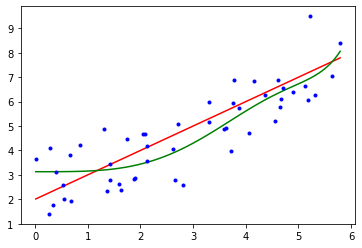

In [17]:
from sklearn.linear_model import ElasticNet

poly_features = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly_features.fit_transform(X)

elastic_reg = ElasticNet(alpha=2.0, l1_ratio=0.5)
elastic_reg.fit(X_poly, y)

X_line_fitted = np.linspace(X.min(), X.max(), num=100)
y_line_fitted = elastic_reg.intercept_
for i in range(len(poly_features.powers_)):
  exponent = poly_features.powers_[i][0]
  y_line_fitted = y_line_fitted + elastic_reg.coef_[i] * (X_line_fitted**exponent)

plt.plot(X_line, y_line, 'r-')
plt.plot(X_line_fitted, y_line_fitted, 'g-')
plt.plot(X, y, 'b.')
plt.show()

## Other Strategies

Aside from regularization, there are other strategies that can be used to prevent overfitting. These include:

* Early stopping
* Cross-validation
* Simplifying your model
* Removing features
* Ensemble methods

# Exercises

For these exercises we will be working with the diabetes dataset that comes packages with Scikit Learn. The code below loads the data and plots BMI vs. S3. We can see from the plots that a polynomial model might work okay for this data.

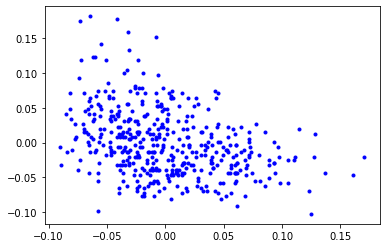

In [18]:
from sklearn.datasets import load_diabetes
import pandas as pd
import matplotlib.pyplot as plt

data = load_diabetes()
df = pd.DataFrame(data.data, columns=[data.feature_names])

X = df['bmi'].values
y = df['s3'].values.ravel()

plt.plot(X.ravel(), y, 'b.')
plt.show()

In [20]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

dataset_filename = "./life_expectancy_years.csv"
life_expectancy_years=pd.read_csv(dataset_filename)

## Exercise 1: Polynomial Regression 

* Create a degree-10 polynomial preprocessor for our regression
* Create a linear regression
* Fit and transform our X values with the polynomial features preprocessor
* Fit our transformed data using the linear regression
* Plot the fitted line over a scatterplot of the data points

### Student Solution

[49.58906899]


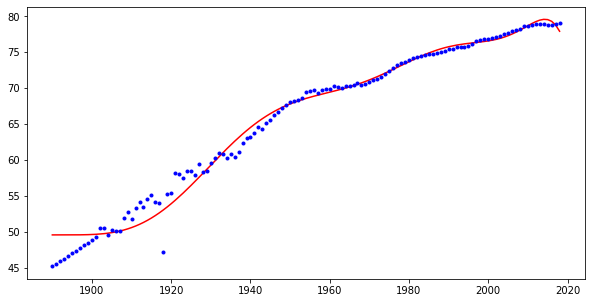

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

year_data = np.array(life_expectancy_years.columns[91:].astype(int)).reshape(-1,1)-1890
United_States = np.asarray(life_expectancy_years.loc[life_expectancy_years['country'] =='United States'].loc[:,'1890':]).reshape(-1,1)

poly_features = PolynomialFeatures(degree=10, include_bias=False)
year_data_poly = poly_features.fit_transform(year_data)
regression = LinearRegression()
regression.fit(year_data_poly,United_States )

year_line_fitted = np.linspace(year_data.min(), year_data.max(), num=129)
year_line_fitted
life_line_fitted = regression.intercept_
print(life_line_fitted)
for i in range(len(poly_features.powers_)):
  exponent = poly_features.powers_[i][0]
  life_line_fitted = life_line_fitted + regression.coef_[0][i] * (year_line_fitted**exponent)
  
plt.figure(figsize=(10,5))
plt.plot(year_line_fitted+1890, life_line_fitted, 'r-')
plt.plot(year_data+1890, United_States, 'b.')
plt.show()

## Exercise 2: Regularization

Copy your code from the exercise above and experiment with the Lasso, Ridge, and/or ElasticNet classes in the place of the `LinearRegression`. Adjust the parameters for whichever regularization class you use until you create a line that doesn't look to be under or over-fitted.

### Student Solution

/Users/dorishuang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.61027312046099, tolerance: 1.3966002015503876
  positive)


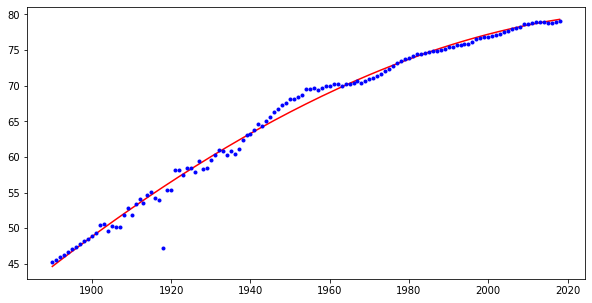

In [22]:
# LASSO without shifting year index 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

year_data = np.array(life_expectancy_years.columns[91:].astype(int)).reshape(-1,1)
United_States = np.asarray(life_expectancy_years.loc[life_expectancy_years['country'] =='United States'].loc[:,'1890':]).reshape(-1,1)

poly_features = PolynomialFeatures(degree=10, include_bias=False)
year_data_poly = poly_features.fit_transform(year_data)

lasso_reg = Lasso(alpha=10.0)
lasso_reg.fit(year_data_poly, United_States)

year_line_fitted = np.linspace(year_data.min(), year_data.max(), num=129)
life_line_fitted = lasso_reg.intercept_

for i in range(len(poly_features.powers_)):
  exponent = poly_features.powers_[i][0]
  life_line_fitted = life_line_fitted + lasso_reg.coef_[i] * (year_line_fitted**exponent)

plt.figure(figsize=(10,5))
plt.plot(year_line_fitted, life_line_fitted, 'r-')
plt.plot(year_data, United_States, 'b.')
plt.show()

/Users/dorishuang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111.05259818696354, tolerance: 1.3966002015503876
  positive)


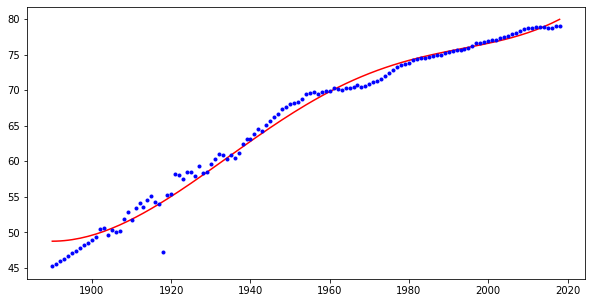

In [23]:
# LASSO with shifting year index 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

year_data = np.array(life_expectancy_years.columns[91:].astype(int)).reshape(-1,1)-1890
United_States = np.asarray(life_expectancy_years.loc[life_expectancy_years['country'] =='United States'].loc[:,'1890':]).reshape(-1,1)

poly_features = PolynomialFeatures(degree=10, include_bias=False)
year_data_poly = poly_features.fit_transform(year_data)

lasso_reg = Lasso(alpha=10.0)
lasso_reg.fit(year_data_poly, United_States)

year_line_fitted = np.linspace(year_data.min(), year_data.max(), num=129)
life_line_fitted = lasso_reg.intercept_

for i in range(len(poly_features.powers_)):
  exponent = poly_features.powers_[i][0]
  life_line_fitted = life_line_fitted + lasso_reg.coef_[i] * (year_line_fitted**exponent)

plt.figure(figsize=(10,5))
plt.plot(year_line_fitted+1890, life_line_fitted, 'r-')
plt.plot(year_data+1890, United_States, 'b.')
plt.show()


/Users/dorishuang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83976e-43): result may not be accurate.
  overwrite_a=True).T


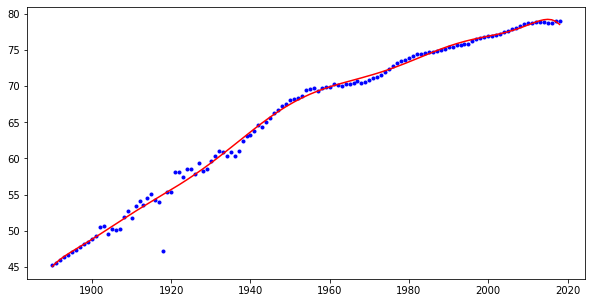

In [24]:
# Ridge with shifting year index 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

year_data = np.array(life_expectancy_years.columns[91:].astype(int)).reshape(-1,1)-1890
United_States = np.asarray(life_expectancy_years.loc[life_expectancy_years['country'] =='United States'].loc[:,'1890':]).reshape(-1,1)

poly_features = PolynomialFeatures(degree=10, include_bias=False)
year_data_poly = poly_features.fit_transform(year_data)

ridge_reg = Ridge(alpha = 0.3)
ridge_reg.fit(year_data_poly, United_States)

year_line_fitted = np.linspace(year_data.min(), year_data.max(), num=129)
life_line_fitted = ridge_reg.intercept_

for i in range(len(poly_features.powers_)):
  exponent = poly_features.powers_[i][0]
  life_line_fitted = life_line_fitted + ridge_reg.coef_[0][i] * (year_line_fitted**exponent)

plt.figure(figsize=(10,5))
plt.plot(year_data+1890, United_States, 'b.')
plt.plot(year_line_fitted+1890, life_line_fitted, 'r-')
plt.show()


/Users/dorishuang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.5613415541634, tolerance: 1.3966002015503876
  positive)


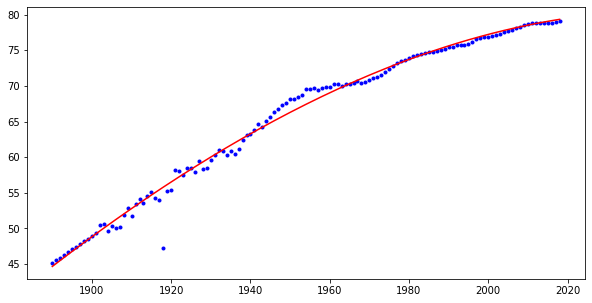

In [25]:
# ElasticNet without shifting year index 
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures

year_data = np.array(life_expectancy_years.columns[91:].astype(int)).reshape(-1,1)
United_States = np.asarray(life_expectancy_years.loc[life_expectancy_years['country'] =='United States'].loc[:,'1890':]).reshape(-1,1)

poly_features = PolynomialFeatures(degree=10, include_bias=False)
year_data_poly = poly_features.fit_transform(year_data)

elastic_reg = ElasticNet(alpha=4.0, l1_ratio=0.8)
elastic_reg.fit(year_data_poly, United_States)

year_line_fitted = np.linspace(year_data.min(), year_data.max(), num=129)
life_line_fitted = elastic_reg.intercept_

for i in range(len(poly_features.powers_)):
  exponent = poly_features.powers_[i][0]
  life_line_fitted = life_line_fitted + elastic_reg.coef_[i] * (year_line_fitted**exponent)

plt.figure(figsize=(10,5))
plt.plot(year_data, United_States, 'b.')
plt.plot(year_line_fitted, life_line_fitted, 'r-')
plt.show()


/Users/dorishuang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140.69370041934812, tolerance: 1.3966002015503876
  positive)


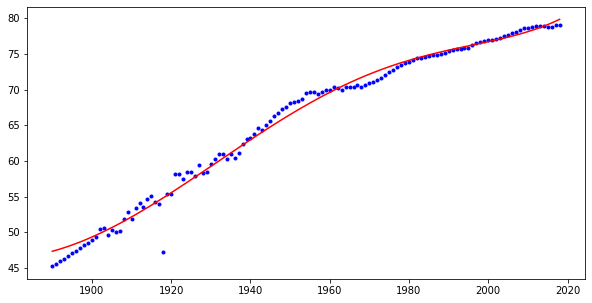

In [26]:
# ElasticNet with shifting year index 
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures

year_data = np.array(life_expectancy_years.columns[91:].astype(int)).reshape(-1,1)-1890
United_States = np.asarray(life_expectancy_years.loc[life_expectancy_years['country'] =='United States'].loc[:,'1890':]).reshape(-1,1)

poly_features = PolynomialFeatures(degree=10, include_bias=False)
year_data_poly = poly_features.fit_transform(year_data)

elastic_reg = ElasticNet(alpha=4.0, l1_ratio=0.8)
elastic_reg.fit(year_data_poly, United_States)

year_line_fitted = np.linspace(year_data.min(), year_data.max(), num=129)
life_line_fitted = elastic_reg.intercept_

for i in range(len(poly_features.powers_)):
  exponent = poly_features.powers_[i][0]
  life_line_fitted = life_line_fitted + elastic_reg.coef_[i] * (year_line_fitted**exponent)

plt.figure(figsize=(10,5))
plt.plot(year_data+1890, United_States, 'b.')
plt.plot(year_line_fitted+1890, life_line_fitted, 'r-')
plt.show()


## Exercise 3: Challenge (Ungraded)

Experiment with the [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) in the place of the `LinearRegression` class. Can you get the SGDRegressor to fit a polynomial curve? After you get a curve to fit, experiment with the `early_stopping` setting on the `SGDRegressor`.

### Student Solution

/Users/dorishuang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


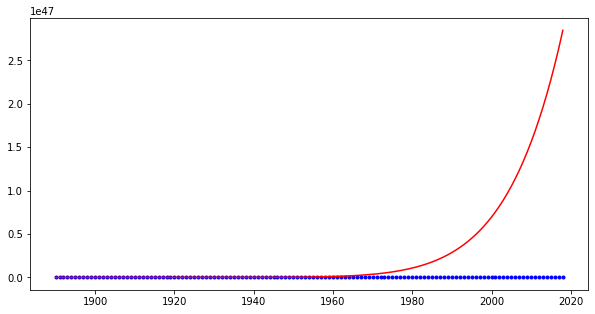

In [27]:
# Your code goes here.
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

year_data = np.array(life_expectancy_years.columns[91:].astype(int)).reshape(-1,1)-1890
United_States = np.asarray(life_expectancy_years.loc[life_expectancy_years['country'] =='United States'].loc[:,'1890':]).reshape(-1,1)


poly_features = PolynomialFeatures(degree=10, include_bias=False)
year_data_poly = poly_features.fit_transform(year_data)


SGD_reg = SGDRegressor(alpha=0.1,early_stopping=True,learning_rate='adaptive')
SGD_reg.fit(year_data_poly, United_States)

year_line_fitted = np.linspace(year_data.min(), year_data.max(), num=129)
life_line_fitted = SGD_reg.intercept_

SGD_reg.coef_

for i in range(len(poly_features.powers_)):
  exponent = poly_features.powers_[i][0]
  life_line_fitted = life_line_fitted + SGD_reg.coef_[i] * (year_line_fitted**exponent)

plt.figure(figsize=(10,5))
plt.plot(year_data+1890, United_States, 'b.')
plt.plot(year_line_fitted+1890, life_line_fitted, 'r-')
plt.show()
